#Introduction

 **BraTS Challenge** focuses on analyzing and segmenting gliomas using multi-parametric MRI (mpMRI) data. The dataset includes:

1. **MRI Modalities**:
   - Native T1-weighted (T1)
   - Post-contrast T1-weighted (T1Gd)
   - T2-weighted (T2)
   - T2 Fluid Attenuated Inversion Recovery (T2-FLAIR)

2. **File Format**:
   - MRI scans are provided as **NIfTI files (.nii.gz)**.

3. **Annotations**:
   - Tumor sub-regions are segmented and labeled as:
     - **GD-enhancing tumor (ET)**: Label 4
     - **Peritumoral edematous/invaded tissue (ED)**: Label 2
     - **Necrotic tumor core (NCR)**: Label 1

4. **Data Preprocessing**:
   - Images are **co-registered** to a common anatomical template.
   - Interpolated to a uniform voxel resolution of **1 mm³**.
   - Skull-stripped.

5. **Clinical Background**:
   - The dataset includes **multi-institutional, routine clinically-acquired mpMRI scans**.
   - All scans are pathologically confirmed and have MGMT promoter methylation status.

This dataset is designed for tasks such as tumor segmentation, classification, or related applications in glioma research. It is pre-processed for consistency and quality and includes detailed ground truth annotations validated by expert neuroradiologists.


 - Segmentation models for 3D data and tasks with pre-built loss functions

In [1]:
!pip install segmentation-models-3D

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.8/69.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 38.3 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0


In [2]:
#Libraries and imports
#Nibabel for reading medical imaging files in NIfTI format (.nii or .nii.gz)
import nibabel as nib
#Numerical computations and importantly array manipulation
import numpy as np
import cv2
import imageio
import random
#File path operations
import os
import shutil
#Pattern matching and retrieving file paths
import glob
#Important visualization for preprocessing and results
import matplotlib.pyplot as plt
#DL library
import tensorflow as tf
from IPython.display import Image, display
from tensorflow import keras
#Autodownload files
from google.colab import files
#Mixed precision for faster computation and reduced memory usage
from tensorflow.keras import mixed_precision
#All layers necessary to UNet model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, concatenate, BatchNormalization, Conv3DTranspose, Cropping3D, ZeroPadding3D
#For Importing model after training
from tensorflow.keras.models import Model, load_model
#Converting segmentation masks into one-hot encoded forms
from tensorflow.keras.utils import to_categorical
#Standard Classification of loss
from tensorflow.keras.losses import CategoricalCrossentropy
#Important callback fo radjusting learning rate while training and saving checkpoints
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
#Splitting data into training and validation sets
from sklearn.model_selection import train_test_split
#Data augmentation like rotating and filtering
from scipy.ndimage import rotate, gaussian_filter
#Loss function for segmentation
from segmentation_models_3D.losses import DiceLoss
#Metrics to evaluatate segmentation accuracy
from segmentation_models_3D.metrics import IOUScore, FScore

Segmentation Models: using `keras` framework.


#EDA

## Data Loading

In [3]:
#Data stored in google drive, access via below import
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Defined base path to the BraTS dataset (unzipped in .nii.gz format)
base_path = '/content/drive/My Drive/BraTS2021/'

In [5]:
#Mixed precision policy set from beginning to optimize memory usage and improve training times
mixed_precision.set_global_policy('mixed_float16')

In [6]:
#Function to load all file paths for each modality (FLAIR, T1, T1CE, T2, and Segmentation)
def load_file_paths(base_path):
    #Initialize empty lists to load all data accordingly
    flair_files = []
    t1_files = []
    t1ce_files = []
    t2_files = []
    seg_files = []

    #For loop to traverse through all folders and subfolders in the base path and find appropriate files
    for root, _, files in os.walk(base_path):
        for file in files:
            #FLAIR Files
            if file.endswith('_flair.nii') or file.endswith('_flair.nii.gz'):
                flair_files.append(os.path.join(root, file))
            #T1 Files
            elif file.endswith('_t1.nii') or file.endswith('_t1.nii.gz'):
                t1_files.append(os.path.join(root, file))
            #T1CE Files
            elif file.endswith('_t1ce.nii') or file.endswith('_t1ce.nii.gz'):
                t1ce_files.append(os.path.join(root, file))
            #T2 Files
            elif file.endswith('_t2.nii') or file.endswith('_t2.nii.gz'):
                t2_files.append(os.path.join(root, file))
            #Segmentation mask files
            elif file.endswith('_seg.nii') or file.endswith('_seg.nii.gz'):
                seg_files.append(os.path.join(root, file))
    return flair_files, t1_files, t1ce_files, t2_files, seg_files

#Load in the file paths for each modality
flair_files, t1_files, t1ce_files, t2_files, seg_files = load_file_paths(base_path)

#Print out the number of files found for each modality to ensure full data loading
print(f"Number of FLAIR files: {len(flair_files)}")
print(f"Number of T1 files: {len(t1_files)}")
print(f"Number of T1CE files: {len(t1ce_files)}")
print(f"Number of T2 files: {len(t2_files)}")
print(f"Number of Segmentation files: {len(seg_files)}")

Number of FLAIR files: 1253
Number of T1 files: 1253
Number of T1CE files: 1253
Number of T2 files: 1253
Number of Segmentation files: 1253


##Data Exploration

In [7]:
#Double check if the number of files is consistent across all modalities and no discrete discrepencies in data
assert len(flair_files) == len(t1_files) == len(t1ce_files) == len(t2_files) == len(seg_files), "Mismatch in the number of files across modalities."
print("All modalities have a consistent number of files.")

All modalities have a consistent number of files.


In [8]:
#Function to load and display the shape of a sample file from each modality
def load_and_verify_sample(flair_file, t1_file, t1ce_file, t2_file, seg_file):
    try:
        #Load and print FLAIR file
        flair_img = nib.load(flair_file)
        print(f"FLAIR shape: {flair_img.shape}")
        #Load and print T1 file
        t1_img = nib.load(t1_file)
        print(f"T1 shape: {t1_img.shape}")
        #T1CE File loading and shape display
        t1ce_img = nib.load(t1ce_file)
        print(f"T1CE shape: {t1ce_img.shape}")
        #T2 File and shape
        t2_img = nib.load(t2_file)
        print(f"T2 shape: {t2_img.shape}")
        #Segmentation file and shape
        seg_img = nib.load(seg_file)
        print(f"Segmentation shape: {seg_img.shape}")
    #Return any loading errors
    except Exception as e:
        print(f"Error loading files: {e}")

#Loading and verification of first sample (and patient) from dataset
load_and_verify_sample(flair_files[0], t1_files[0], t1ce_files[0], t2_files[0], seg_files[0])

FLAIR shape: (240, 240, 155)
T1 shape: (240, 240, 155)
T1CE shape: (240, 240, 155)
T2 shape: (240, 240, 155)
Segmentation shape: (240, 240, 155)


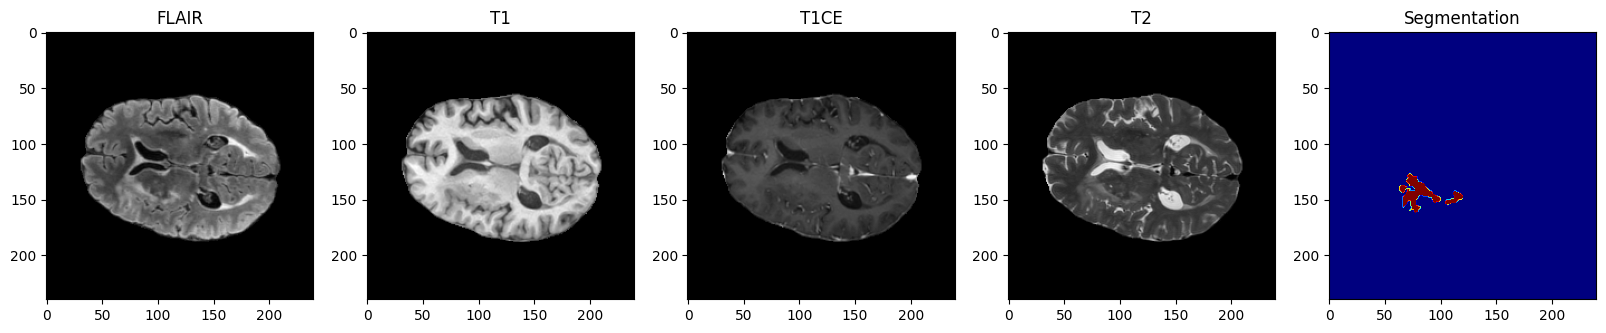

In [9]:
#Display slices from all modalities for a given sample
def visualize_sample(flair_file, t1_file, t1ce_file, t2_file, seg_file, slice_idx=None):
    #Load volumes, files
    flair = nib.load(flair_file).get_fdata()
    t1 = nib.load(t1_file).get_fdata()
    t1ce = nib.load(t1ce_file).get_fdata()
    t2 = nib.load(t2_file).get_fdata()
    seg = nib.load(seg_file).get_fdata()

    #Use the middle slice if no slice index is provided
    slice_idx = slice_idx or flair.shape[2] // 2

    #Plot all modalities and segmentation mask
    fig, axes = plt.subplots(1, 5, figsize=(20, 10))
    axes[0].imshow(flair[:, :, slice_idx], cmap='gray')
    axes[0].set_title("FLAIR")
    axes[1].imshow(t1[:, :, slice_idx], cmap='gray')
    axes[1].set_title("T1")
    axes[2].imshow(t1ce[:, :, slice_idx], cmap='gray')
    axes[2].set_title("T1CE")
    axes[3].imshow(t2[:, :, slice_idx], cmap='gray')
    axes[3].set_title("T2")
    axes[4].imshow(seg[:, :, slice_idx], cmap='jet')
    axes[4].set_title("Segmentation")
    plt.show()

# Visualize the first sample
visualize_sample(flair_files[0], t1_files[0], t1ce_files[0], t2_files[0], seg_files[0])

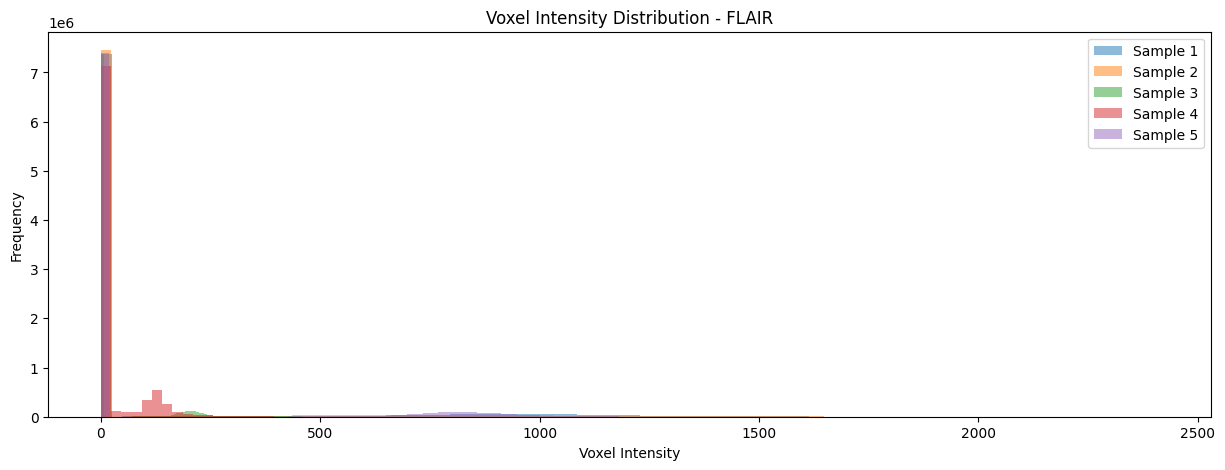

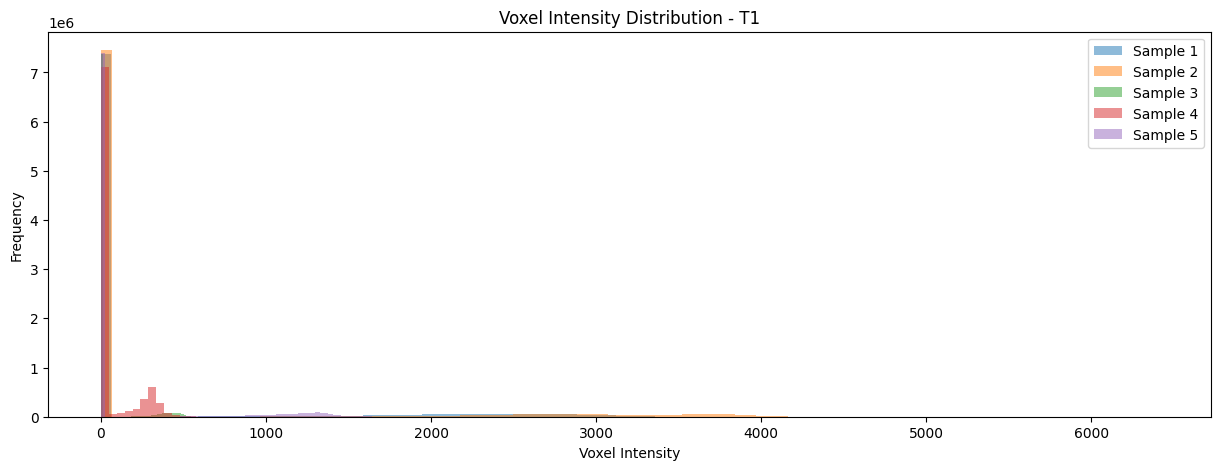

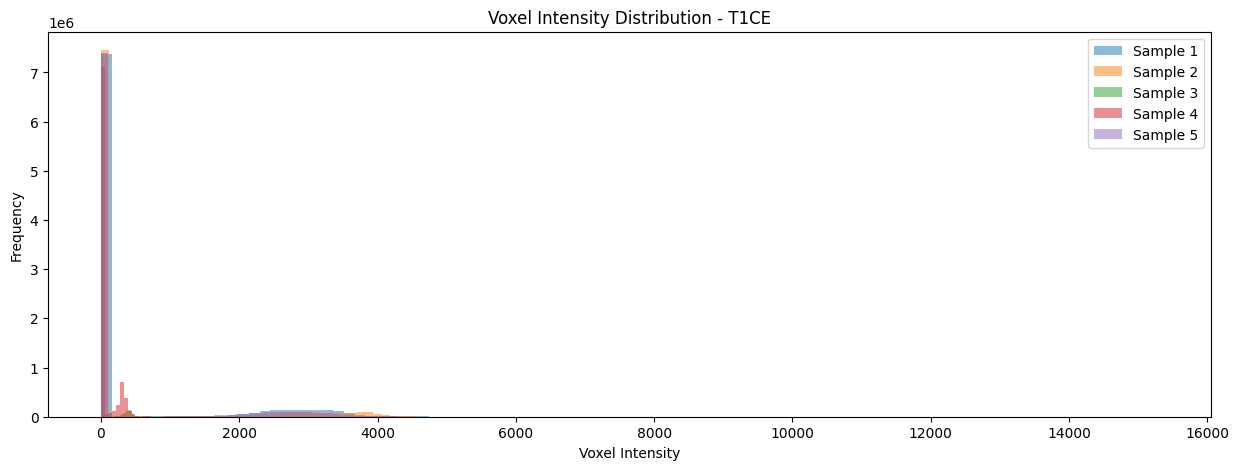

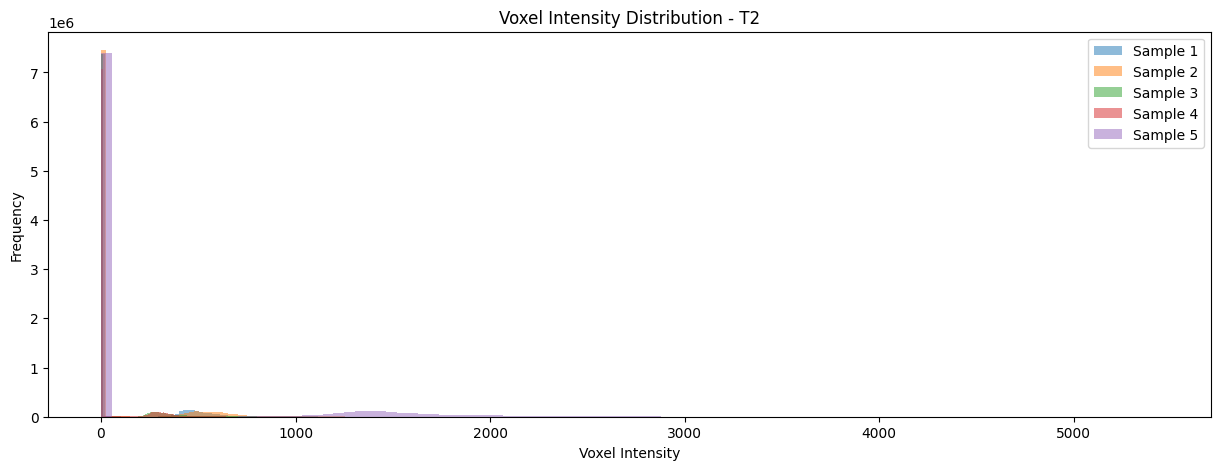

In [10]:
#Histograms for voxel intensities
def plot_voxel_distributions(file_paths, modality_name, num_samples=5):
    plt.figure(figsize=(15, 5))
    #Check first few samples
    for i, file_path in enumerate(file_paths[:num_samples]):
        #Load volume data from file
        volume = nib.load(file_path).get_fdata()
        #Plot intensity
        plt.hist(volume.flatten(), bins=100, alpha=0.5, label=f"Sample {i+1}")
    plt.title(f"Voxel Intensity Distribution - {modality_name}")
    plt.xlabel("Voxel Intensity")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

# Plot distributions for each modality
plot_voxel_distributions(flair_files, "FLAIR")
plot_voxel_distributions(t1_files, "T1")
plot_voxel_distributions(t1ce_files, "T1CE")
plot_voxel_distributions(t2_files, "T2")

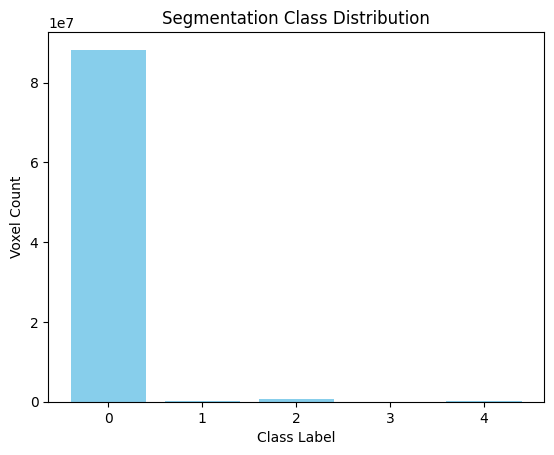

In [11]:
#Class distribution in segmentation masks
def plot_class_distribution(seg_files, num_samples=10):
    #Initialize count array for classes
    class_counts = np.zeros(5)
    #Iterate over first few segmentations
    for seg_file in seg_files[:num_samples]:
        #Load up segmentations
        seg = nib.load(seg_file).get_fdata()
        #Get unique labels and counts
        unique, counts = np.unique(seg, return_counts=True)
        for u, c in zip(unique, counts):
            class_counts[int(u)] += c

    plt.bar(range(len(class_counts)), class_counts, color='skyblue')
    plt.title("Segmentation Class Distribution")
    plt.xlabel("Class Label")
    plt.ylabel("Voxel Count")
    plt.xticks(range(len(class_counts)))
    plt.show()

#Plot the class distribution for the first 10 segmentation masks
plot_class_distribution(seg_files)

 - There are some images without tangible information. Need to search and find.

##Training Split

In [12]:
#Data splitting for training and validating. Will approach with standard 80/20 split
indices = list(range(len(flair_files)))
train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=37)
#Print amount of instances in each to verify proper split
print(f"Number of training samples: {len(train_indices)}")
print(f"Number of validation samples: {len(val_indices)}")

Number of training samples: 1002
Number of validation samples: 251


In [13]:
#Data Generator for data loading and preprocessing across full dataset
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, indices, batch_size=2, augment=False, useful_threshold=0.03):
        #Indices of dataset
        self.indices = indices
        #Samples per batch
        self.batch_size = batch_size
        #Applying data augmentation
        self.augment = augment
        #Threshold for uesful data based on non-zero voxel proportion
        self.useful_threshold = useful_threshold

    def __len__(self):
        #Calculate number of batches per epoch to understand resource allocation
        return int(np.ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, index):
        #Fetch one batch of data based on index with batch specific indices
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        #Initialized lists for input data and lables (X and y respectively)
        X, y = [], []
        for i in batch_indices:
            #Load all modalities for given index (up to 1253)
            flair = nib.load(flair_files[i]).get_fdata()
            t1 = nib.load(t1_files[i]).get_fdata()
            t1ce = nib.load(t1ce_files[i]).get_fdata()
            t2 = nib.load(t2_files[i]).get_fdata()
            seg = nib.load(seg_files[i]).get_fdata()

            #Check if the data volume contains enough "useful" non-zero voxels
            if (
                self._useful_volume(flair) < self.useful_threshold or
                self._useful_volume(t1) < self.useful_threshold or
                self._useful_volume(t1ce) < self.useful_threshold or
                self._useful_volume(t2) < self.useful_threshold
            ):
                print(f"[INFO] Skipping patient {i} due to insufficient useful volume.")
                continue

            #Stack modalities as channels along last axis
            input_image = np.stack([flair, t1, t1ce, t2], axis=-1)

            #Pad the depth dimension from 155 to 160 so we can feed it through the model w/o error
            pad_diff = 160 - input_image.shape[2]
            #If depth is less than 160, pad with 0
            if pad_diff > 0:
                input_image = np.pad(input_image, ((0, 0), (0, 0), (0, pad_diff), (0, 0)), mode='constant')
                seg = np.pad(seg, ((0, 0), (0, 0), (0, pad_diff)), mode='constant')

            #Normalize each modality independently to [0,1]
            input_image[..., 0] = self._normalize(input_image[..., 0])
            input_image[..., 1] = self._normalize(input_image[..., 1])
            input_image[..., 2] = self._normalize(input_image[..., 2])
            input_image[..., 3] = self._normalize(input_image[..., 3])

            #Convert segmentation mask to categorical format for multi-class segmentation
            seg = to_categorical(seg, num_classes=5)

            #Data augmentation
            if self.augment:
                #Randomly decide to augment
                if random.random() > 0.5:
                    #Generate random rotation angle
                    angle = random.uniform(-10, 10)
                    #Rotate image
                    input_image = rotate(input_image, angle, axes=(0, 1), reshape=False, mode='nearest')
                    #Rotate segmentation mask
                    seg = rotate(seg, angle, axes=(0, 1), reshape=False, mode='nearest')
            #Append preprocessed input to batch
            X.append(input_image)
            #Append preprocessed segmentation to batch too
            y.append(seg)
        #Return as Numpy array
        return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

    def _normalize(self, volume):
        """Normalize a 3D volume to the range [0, 1]."""
        return (volume - np.min(volume)) / (np.max(volume) - np.min(volume))

    def _useful_volume(self, volume):
        """Calculate the proportion of useful volume (non-zero voxels)."""
        return 1 - (np.sum(volume == 0) / volume.size)

In [14]:
#Instantiate training and validation generators
train_generator = DataGenerator(indices=train_indices, batch_size=4, augment=True, useful_threshold=0.03)
val_generator = DataGenerator(indices=val_indices, batch_size=4, augment=False, useful_threshold=0.03)

In [15]:
#Training instances applied
train_total_instances = len(train_generator.indices)
print(f"Total number of training instances: {train_total_instances}")

#Validation instances applied
val_total_instances = len(val_generator.indices)
print(f"Total number of validation instances: {val_total_instances}")

Total number of training instances: 1002
Total number of validation instances: 251


In [16]:
#Convert training and validation data generators into Tensorflow datsets
#pass training data generator
train_dataset = tf.data.Dataset.from_generator(lambda: train_generator, output_signature=(
    #Input shape and type
    tf.TensorSpec(shape=(None, 240, 240, 160, 4), dtype=tf.float32),
    #Output shape and type
    tf.TensorSpec(shape=(None, 240, 240, 160, 5), dtype=tf.float32))
)

val_dataset = tf.data.Dataset.from_generator(lambda: val_generator, output_signature=(
    #input shape, type
    tf.TensorSpec(shape=(None, 240, 240, 160, 4), dtype=tf.float32),
    #Output shape, type
    tf.TensorSpec(shape=(None, 240, 240, 160, 5), dtype=tf.float32))
)

#Prefetch data to improve performance during training
train_dataset = train_dataset.batch(1).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(1).prefetch(tf.data.experimental.AUTOTUNE)

In [18]:
def enhanced_unet_model(input_shape):
    #Input layer accepting 3D image with 4 channels (1 per modality)
    inputs = Input(input_shape)

    #Contracting Path (Encoder)
    #First block is to extrat features and reduce spatial dimesnions
    #Begin with 32 filter convolutional layer
    conv1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(inputs)
    #Normalize activations (improves convergence)
    conv1 = BatchNormalization()(conv1)
    #Additional convolution
    conv1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    #Downsample volume by factor of 2
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)

    #Second block with deeper feature extraction
    conv2 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)

    #Third block (feature extraction continued)
    conv3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling3D(pool_size=(2, 2, 2))(conv3)

    #Bottleneck. Captures high level features with reduced spatial resolution
    conv4 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)

    #First Expansive Path (Decoder)
    #First block: Upsample and concatenate features from the contracting path
    up5 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv4)
    #Skip connection with corresponding encoder layer
    up5 = concatenate([up5, conv3], axis=-1)
    conv5 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(up5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)

    #Second block with continued upsampling and concatenating
    up6 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv5)
    up6 = concatenate([up6, conv2], axis=-1)
    conv6 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)

    #Third block with upsampling
    up7 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv6)
    up7 = concatenate([up7, conv1], axis=-1)
    conv7 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    #Output layer with prediction of segmentation map with 5 classes (softmax generates probabilities to determine)
    outputs = Conv3D(5, (1, 1, 1), activation='softmax')(conv7)

    #Model variable with input/output layers
    model = Model(inputs=[inputs], outputs=[outputs])
    return model


#Input shape with even depth to prevent mismatches
#Depth is even number (power of 2) with 4 channels
input_shape = (240, 240, 160, 4)
#instantiate model
model = enhanced_unet_model(input_shape)
#Summarize model architecture for parameter check
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 240, 240, 160,  │              0 │ -                      │
│ (InputLayer)              │ 4)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_5 (Conv3D)         │ (None, 240, 240, 160,  │            872 │ input_layer_1[0][0]    │
│                           │ 8)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_2           │ (None, 120, 120, 80,   │              0 │ conv3d_5[0][0]         │
│ (MaxPooling3D)            │ 8)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_6 (Conv3D)         │ (None, 120, 120, 80,   │          3,472 │ max_pooling3d_2[0][0]  │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_3           │ (None, 60, 60, 40, 16) │              0 │ conv3d_6[0][0]         │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_7 (Conv3D)         │ (None, 60, 60, 40, 32) │         13,856 │ max_pooling3d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling3d_2           │ (None, 120, 120, 80,   │              0 │ conv3d_7[0][0]         │
│ (UpSampling3D)            │ 32)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 120, 120, 80,   │              0 │ up_sampling3d_2[0][0], │
│ (Concatenate)             │ 48)                    │                │ conv3d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_8 (Conv3D)         │ (None, 120, 120, 80,   │         20,752 │ concatenate_2[0][0]    │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling3d_3           │ (None, 240, 240, 160,  │              0 │ conv3d_8[0][0]         │
│ (UpSampling3D)            │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 240, 240, 160,  │              0 │ up_sampling3d_3[0][0], │
│ (Concatenate)             │ 24)                    │                │ conv3d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_9 (Conv3D)         │ (None, 240, 240, 160,  │          5,192 │ concatenate_3[0][0]    │
│                           │ 8)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_10 (Conv3D)        │ (None, 240, 240, 160,  │             45 │ conv3d_9[0][0]         │
│                           │ 5)                     │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 44,189 (172.61 KB)

 Trainable params: 44,189 (172.61 KB)

 Non-trainable params: 0 (0.00 B)

**OPTIMIZED CHANGES HERE**

In [19]:
#Dice loss to measure overlap between predicted mask and ground truth
dice_loss = DiceLoss()
#Penalize pixel-wize misclassifications
crossentropy_loss = CategoricalCrossentropy()

In [20]:
#Combined losses to balance region-level and pizel-level accuracy
def combined_loss(y_true, y_pred):
    return dice_loss(y_true, y_pred) + crossentropy_loss(y_true, y_pred)

In [21]:
#Metrics for segmentation performace
#Intersection-Over-Union for overlap eval
#F1 Score for region precision/recall
#Pizel-wise accuracy
metrics = [IOUScore(threshold=0.5), FScore(threshold=0.5), 'accuracy']

In [22]:
#Reduced learning rate when validation loss stops improving
reduce_lr = ReduceLROnPlateau(
    #Validation loss
    monitor='val_loss',
    #One-third the learning rate
    factor=0.3,
    #Wait 2 epochs without improvement
    patience=2,
    #Minimum LR
    min_lr=1e-4,
    #Print updates
    verbose=1
)

In [23]:
# Define the checkpoint callback with dynamic epoch-based filenames
checkpoint = ModelCheckpoint(
    #Model name w/ epoch
    filepath='model_checkpoint_epoch_{epoch:02d}.keras',
    #Validation loss
    monitor='val_loss',
    #only best model is saved
    save_best_only=True,
    #When val loss is minimized
    mode='min',
    #print out information on model
    verbose=1
)

In [24]:
#Hopefully prevents overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    #Stop when val loss doesnt improve
    monitor='val_loss',
    #Wait 3 epochs before stopping
    patience=3,
    #Revert to best weights
    restore_best_weights=True
    )

In [25]:
#Compile the model with loss, optimizer, metrics
model.compile(optimizer='adam', loss=combined_loss, metrics=metrics)

In [ ]:
#Train model with generators, callbacks
history = model.fit(
    #Data Generator
    train_generator,
    #Validation generator
    validation_data=val_generator,
    #Iterations, try few others next
    epochs=1,
    #Display progress during training
    verbose=1,
    #Learning rate reduction, early stopping
    callbacks=[reduce_lr, early_stopping, checkpoint]
    )

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  6/251 ━━━━━━━━━━━━━━━━━━━━ 4:10:20 61s/step - accuracy: 0.9367 - f1-score: 0.2073 - iou_score: 0.2041 - loss: 2.4514

**Metrics Visualized**

In [ ]:
def plot_training_metrics(history):
    """
    Plots training and validation metrics over epochs.

    Parameters:
        history: History object returned by model.fit(), containing training and validation metrics.
    """
    # Extract metrics from history
    metrics = [key for key in history.history.keys() if not key.startswith("val_")]
    for metric in metrics:
        plt.figure(figsize=(10, 8))
        plt.plot(history.history[metric], label=f"Training {metric}")
        if f"val_{metric}" in history.history:
            plt.plot(history.history[f"val_{metric}"], label=f"Validation {metric}")
        plt.title(f"{metric.capitalize()} Over Epochs")
        plt.xlabel("Epochs")
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.grid()
        plt.show()

In [ ]:
plot_training_metrics(history)

In [ ]:
#Save trained model for later use
model.save('Modified_Model_3_epochs.keras')

In [ ]:
#Automatically download model and checkpoints
#Double check pathing
def download_model_checkpoints(folder_path="./"):
    if not os.path.exists(folder_path):
        print(f"Error: Folder '{folder_path}' does not exist.")
        return

    #Collect all .keras files in local directory
    keras_files = [f for f in os.listdir(folder_path) if f.endswith('.keras')]
    if not keras_files:
        print("No .keras files found in the specified folder.")
        return

    #Define Zip Folder
    zip_file_name = "Model_Iter_1.keras.zip"

    #Zip only the .keras files
    with shutil.ZipFile(zip_file_name, 'w') as zipf:
        for file in keras_files:
            zipf.write(os.path.join(folder_path, file), arcname=file)
    print(f"Zipped .keras files from '{folder_path}' as '{zip_file_name}'")

    #Download zipped file
    try:
        files.download(zip_file_name)
        print("Download started...")
    except Exception as e:
        print(f"Error during download: {e}")

In [ ]:
#Save everything
download_model_checkpoints()

 - Below code is only to be run once training finishes

In [ ]:
'''
#Load the best checkpoint or model entirely (Example)
model = load_model('model_checkpoint_epoch_03.keras',
                   custom_objects={'IOUScore': IOUScore, 'FScore': FScore, 'DiceLoss': DiceLoss},
                   compile=True)
#Verify metrics are loaded (IOU score, F1 score, accuracy)
print(model.metrics_names)

#Can resume training with
model.fit(train_generator, validation_data=val_generator, epochs=10)
'''

**ADD STEP TO AUTOMATICALLY DOWNLOAD FILE**

##Results Visualized

In [ ]:
#Refine the predicted segmentation masks
def post_process_prediction(prediction):
    #Convert predictions to class labels
    prediction = prediction.argmax(axis=-1)
    #Apply morphological closing to fill gaps and remove noise
    #Loop through each slice in depth
    for i in range(prediction.shape[2]):
        #Convert to 8-bit for morphological operations, use 5x5 kernel
        prediction[:, :, i] = cv2.morphologyEx(prediction[:, :, i].astype(np.uint8), cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8))
    return prediction

In [ ]:
def add_outline(image, mask, outline_color=(255, 0, 0)):
    """
    Adds an outline of the mask onto the image using edge detection.

    Parameters:
        image (ndarray): The original grayscale input image.
        mask (ndarray): The segmentation mask.
        outline_color (tuple): RGB color for the outline (default: red).

    Returns:
        ndarray: Image with the mask outline overlayed.
    """
    # Normalize the input image to range [0, 255] if necessary
    image = (image - image.min()) / (image.max() - image.min()) * 255
    image = image.astype(np.uint8)

    # Detect edges using Canny edge detection
    edges = cv2.Canny(mask.astype(np.uint8) * 255, threshold1=50, threshold2=150)

    # Convert grayscale image to RGB
    overlay = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    # Add the outline to the RGB image
    overlay[edges > 0] = outline_color  # Apply outline color to the edges

    return overlay

In [ ]:
def print_class_color_mapping(mask):
    """
    Prints the class-color mapping for the segmentation mask.

    Parameters:
        mask (ndarray): Segmentation mask to analyze.
    """
    unique_labels = np.unique(mask)
    colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))[:, :3] * 255  # Generate unique colors

    print("Class-Color Mapping:")
    for label, color in zip(unique_labels, colors):
        print(f"Class {int(label)}: RGB {tuple(color.astype(int))}")


In [ ]:
def plot_predictions_with_colored_segmentation(model, index):
    """
    Plots the input, ground truth, and predicted segmentation with the colored segmentation and outline,
    and prints the class-color mapping.

    Parameters:
        model: Trained model for prediction.
        index: Index of the sample to visualize.
    """
    # Grab input and ground truth for the batch
    X, y_true = train_generator[index]
    # Predict segmentation
    y_pred = model.predict(X)[0]
    # Apply post-processing
    y_pred_post_processed = post_process_prediction(y_pred)
    # Extract a single slice for visualization
    input_slice = X[0][:, :, X[0].shape[2] // 2, 0]
    ground_truth_slice = y_true[0][:, :, X[0].shape[2] // 2].argmax(axis=-1)
    predicted_slice = y_pred_post_processed[:, :, X[0].shape[2] // 2]

    # Print the class-color mapping
    print("Predicted Segmentation Class-Color Mapping:")
    print_class_color_mapping(predicted_slice)

    # Add colored segmentation and outline
    predicted_with_colors_and_outline = add_colored_segmentation_with_outline(input_slice, predicted_slice)

    # Plot truth, input, predictions, and overlayed segmentation with outline
    fig, axes = plt.subplots(1, 4, figsize=(24, 6))
    axes[0].imshow(input_slice, cmap='gray')
    axes[0].set_title('Input FLAIR Slice')
    axes[1].imshow(ground_truth_slice, cmap='jet')
    axes[1].set_title('Ground Truth Segmentation')
    axes[2].imshow(predicted_slice, cmap='jet')
    axes[2].set_title('Predicted Segmentation (Post-Processed)')
    axes[3].imshow(predicted_with_colors_and_outline)
    axes[3].set_title('Predicted Segmentation with Colors and Outline')
    plt.show()


In [ ]:
def add_colored_segmentation_with_outline(image, mask, outline_color=(255, 0, 0)):
    """
    Adds the segmentation mask and its outline to the image.

    Parameters:
        image (ndarray): The original grayscale input image.
        mask (ndarray): The segmentation mask (with class labels).
        outline_color (tuple): RGB color for the outline (default: red).

    Returns:
        ndarray: Image with the segmentation mask and outline overlayed.
    """
    # Normalize the input image to range [0, 255] if necessary
    image = (image - image.min()) / (image.max() - image.min()) * 255
    image = image.astype(np.uint8)

    # Convert grayscale image to RGB
    overlay = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    # Create a colored version of the mask
    colored_mask = np.zeros_like(overlay)
    unique_labels = np.unique(mask)
    colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))[:, :3] * 255  # Generate unique colors

    for label, color in zip(unique_labels, colors):
        colored_mask[mask == label] = color  # Assign color to each label

    # Blend the colored mask with the image
    alpha = 0.5  # Transparency factor
    overlay = cv2.addWeighted(overlay, 1 - alpha, colored_mask, alpha, 0)

    # Detect edges in the mask for the outline
    edges = cv2.Canny(mask.astype(np.uint8) * 255, threshold1=50, threshold2=150)
    overlay[edges > 0] = outline_color  # Apply outline color to the edges

    return overlay

In [ ]:
def create_3d_gif_with_flair(model, index, flair_output_path="flair_images.gif", segmentation_output_path="predicted_segmentation.gif"):
    """
    Creates two looping 3D GIFs:
    - Original FLAIR images.
    - Predicted segmentation with colors and outlines.

    Parameters:
        model: Trained model for prediction.
        index: Index of the sample to visualize.
        flair_output_path (str): Path to save the FLAIR images GIF.
        segmentation_output_path (str): Path to save the predicted segmentation GIF.
    """
    # Grab input and ground truth for the batch
    X, _ = train_generator[index]
    # Predict segmentation
    y_pred = model.predict(X)[0]
    # Apply post-processing
    y_pred_post_processed = post_process_prediction(y_pred)

    # Print class-color mapping for the first slice
    print("Class-Color Mapping for the First Predicted Slice:")
    print_class_color_mapping(y_pred_post_processed[:, :, 0])

    # Prepare directories for temporary frames
    temp_flair_dir = "temp_flair_frames"
    temp_seg_dir = "temp_seg_frames"
    os.makedirs(temp_flair_dir, exist_ok=True)
    os.makedirs(temp_seg_dir, exist_ok=True)

    # Create individual frames for each slice
    flair_frames = []
    seg_frames = []
    for i in range(X[0].shape[2]):  # Iterate through all slices in the depth dimension
        input_slice = X[0][:, :, i, 0]  # Extract the input FLAIR slice
        predicted_slice = y_pred_post_processed[:, :, i]  # Extract the predicted segmentation for the slice

        # Save FLAIR slice as a frame
        flair_frame_path = os.path.join(temp_flair_dir, f"flair_frame_{i:03d}.png")
        plt.figure(figsize=(5, 5))
        plt.imshow(input_slice, cmap="gray")
        plt.title(f"FLAIR Slice {i}")
        plt.axis("off")
        plt.tight_layout()
        plt.savefig(flair_frame_path, bbox_inches="tight", pad_inches=0)
        plt.close()
        flair_frames.append(flair_frame_path)

        # Add colored segmentation and outline
        overlay = add_colored_segmentation_with_outline(input_slice, predicted_slice)

        # Save segmentation slice as a frame
        seg_frame_path = os.path.join(temp_seg_dir, f"seg_frame_{i:03d}.png")
        plt.figure(figsize=(5, 5))
        plt.imshow(overlay)
        plt.title(f"Predicted Segmentation Slice {i}")
        plt.axis("off")
        plt.tight_layout()
        plt.savefig(seg_frame_path, bbox_inches="tight", pad_inches=0)
        plt.close()
        seg_frames.append(seg_frame_path)

    # Create the FLAIR GIF
    with imageio.get_writer(flair_output_path, mode="I", duration=0.1, loop=0) as writer:
        for frame in flair_frames:
            image = imageio.imread(frame)
            writer.append_data(image)

    # Create the Segmentation GIF
    with imageio.get_writer(segmentation_output_path, mode="I", duration=0.1, loop=0) as writer:
        for frame in seg_frames:
            image = imageio.imread(frame)
            writer.append_data(image)

    # Clean up temporary frames
    for frame in flair_frames:
        os.remove(frame)
    os.rmdir(temp_flair_dir)

    for frame in seg_frames:
        os.remove(frame)
    os.rmdir(temp_seg_dir)

    print(f"FLAIR GIF saved as {flair_output_path}")
    print(f"Segmentation GIF saved as {segmentation_output_path}")

    # Display the GIFs in the notebook
    print("Displaying FLAIR GIF:")
    display(Image(flair_output_path))
    print("Displaying Segmentation GIF:")
    display(Image(segmentation_output_path))


In [ ]:
create_3d_gif_with_flair(
    model,
    index=0,
    flair_output_path="flair_images.gif",
    segmentation_output_path="predicted_segmentation.gif"
)

In [ ]:
# Visualize predictions with colored segmentation and outline
def plot_predictions_with_colored_segmentation(model, index):
    """
    Plots the input, ground truth, and predicted segmentation with the colored segmentation and outline.

    Parameters:
        model: Trained model for prediction.
        index: Index of the sample to visualize.
    """
    # Grab input and ground truth for the batch
    X, y_true = train_generator[index]
    # Predict segmentation
    y_pred = model.predict(X)[0]
    # Apply post-processing
    y_pred_post_processed = post_process_prediction(y_pred)
    # Extract a single slice for visualization
    input_slice = X[0][:, :, X[0].shape[2] // 2, 0]
    ground_truth_slice = y_true[0][:, :, X[0].shape[2] // 2].argmax(axis=-1)
    predicted_slice = y_pred_post_processed[:, :, X[0].shape[2] // 2]

    # Add colored segmentation and outline
    predicted_with_colors_and_outline = add_colored_segmentation_with_outline(input_slice, predicted_slice)

    # Plot truth, input, predictions, and overlayed segmentation with outline
    fig, axes = plt.subplots(1, 4, figsize=(24, 6))
    axes[0].imshow(input_slice, cmap='gray')
    axes[0].set_title('Input FLAIR Slice')
    axes[1].imshow(ground_truth_slice, cmap='jet')
    axes[1].set_title('Ground Truth Segmentation')
    axes[2].imshow(predicted_slice, cmap='jet')
    axes[2].set_title('Predicted Segmentation (Post-Processed)')
    axes[3].imshow(predicted_with_colors_and_outline)
    axes[3].set_title('Predicted Segmentation with Colors and Outline')
    plt.show()

# Example usage
plot_predictions_with_colored_segmentation(model, index=0)

In [ ]:

# Visualize predictions with improved outline overlay
def plot_predictions_with_outline(model, index):
    """
    Plots the input, ground truth, and predicted segmentation with an improved outline overlay.

    Parameters:
        model: Trained model for prediction.
        index: Index of the sample to visualize.
    """
    # Grab input and ground truth for the batch
    X, y_true = train_generator[index]
    # Predict segmentation
    y_pred = model.predict(X)[0]
    # Apply post-processing
    y_pred_post_processed = post_process_prediction(y_pred)
    # Extract a single slice for visualization
    input_slice = X[0][:, :, X[0].shape[2] // 2, 0]
    ground_truth_slice = y_true[0][:, :, X[0].shape[2] // 2].argmax(axis=-1)
    predicted_slice = y_pred_post_processed[:, :, X[0].shape[2] // 2]

    # Add outline to the predicted segmentation
    predicted_with_outline = add_outline(input_slice, predicted_slice, outline_color=(255, 0, 0))

    # Plot truth, input, predictions, and overlayed outline
    fig, axes = plt.subplots(1, 4, figsize=(24, 6))
    axes[0].imshow(input_slice, cmap='gray')
    axes[0].set_title('Input FLAIR Slice')
    axes[1].imshow(ground_truth_slice, cmap='jet')
    axes[1].set_title('Ground Truth Segmentation')
    axes[2].imshow(predicted_slice, cmap='jet')
    axes[2].set_title('Predicted Segmentation (Post-Processed)')
    axes[3].imshow(predicted_with_outline)
    axes[3].set_title('Predicted Segmentation with Brain Outline')
    plt.show()

In [ ]:
# Example usage
plot_predictions_with_outline(model, index=0)

-------------------------- Double Check ------------------

In [ ]:
#Visualize with post-processing
def plot_predictions(model, index):
    #Grab input and ground truth for batch
    X, y_true = train_generator[index]
    #Predict segmentation
    y_pred = model.predict(X)[0]
    #Apply post-processing
    y_pred_post_processed = post_process_prediction(y_pred)

    #Plot truth, input, and predictions
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes[0].imshow(X[0][:, :, X[0].shape[2] // 2, 0], cmap='gray')
    axes[0].set_title('Input FLAIR Slice')
    axes[1].imshow(y_true[0][:, :, X[0].shape[2] // 2].argmax(axis=-1), cmap='jet')
    axes[1].set_title('Ground Truth Segmentation')
    axes[2].imshow(y_pred_post_processed[:, :, X[0].shape[2] // 2], cmap='jet')
    axes[2].set_title('Predicted Segmentation (Post-Processed)')
    plt.show()

plot_predictions(model, index=0)